In [1]:
import numpy as np
import pickle
import torch
import time
import matplotlib.pyplot as plt
import sys
sys.path.append('../')
import src.learning as lrn
from src.safetymaps import StaticSafetyMap, DynamicSafetyMap
from src.reachsteering import HdaGreedy, HdaReachSteering
from src.visualization import *
%load_ext autoreload
%autoreload 2
%matplotlib inline

c:\Users\ktomita3\.conda\envs\pygmo3\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
with open('../saved/controllable_set/lander.pkl', 'rb') as f:
        lander = pickle.load(f)

hidden_layers = [256, 256, 256]
nn_reach = lrn.NeuralReach(hidden_layers=hidden_layers)
nn_reach.load_state_dict(torch.load('../saved/controllable_set/reachset_train/20231115-025054/models_20231130-175526/mlp_reach/mlp_reach.pt'))
nn_reach.eval()

#sfmap_model = StaticSafetyMap(x_range=(-300, 300), y_range=(-300, 300), npoints=100)
sfmap_model = DynamicSafetyMap(x_range=(-300, 300), y_range=(-300, 300), npoints=100, relative_path="..")

x0_init = np.array([-100.0, 0.0, 1300.0, 20.0, 5, -55.0, lander.mwet])
tof = 60.0
T = 5.0
dt = 0.5

In [ ]:

n = 100
x0_list = []
for _ in range(n):
    x0 = np.random.uniform(
        low=[-100.0, -100.0, 1300.0, -20.0, -20.0, -60.0, lander.mwet],
        high=[100.0, 100.0, 1300.0, 20.0, 20.0, -50.0, lander.mwet],
    )

    x0_list.append(x0)

In [ ]:
mean_safety_history_list_greedy = []
mean_safety_history_list_reach = []

for x0_init in x0_list:
    greedy = HdaGreedy(lander, sfmap_model, x0, tof, T, dt, nn_reach)
    greedy.solve_hda(x0_init, tof, T, dt)
    mean_safety_history_list_greedy.append(greedy.mean_safety_history)

    reach = HdaReachSteering(lander, sfmap_model, x0, tof, T, dt, nn_reach)
    reach.solve_hda(x0_init, tof, T, dt)
    mean_safety_history_list_reach.append(reach.mean_safety_history)

In [3]:
hda_greedy = HdaGreedy(lander, sfmap_model, nn_reach, border_sharpness=10.0)
hda_greedy.solve_hda(x0_init, tof, T, dt)

x0: [-100.    0. 1300.   20.    5.  -55. 1905.], tgo: 60.0
Greedy HDA optimized single leg: 4.398703575134277 sec
x0: [-3.91204939e+01  1.13961704e+01  1.05549349e+03  5.22143299e+00
 -8.57690937e-02 -4.22420109e+01  1.87497622e+03], tgo: 55.0
Greedy HDA optimized single leg: 1.6494202613830566 sec
x0: [-2.66971867e+01  7.78500875e+00  8.85547479e+02  2.48158213e-01
 -1.18710772e+00 -2.55647628e+01  1.84495661e+03], tgo: 50.0
Greedy HDA optimized single leg: 1.3857715129852295 sec
x0: [-2.88872974e+01  2.43105735e+00  8.01477354e+02 -1.08291312e+00
 -9.54845266e-01 -7.96397628e+00  1.81494891e+03], tgo: 45.0
Greedy HDA optimized single leg: 1.2412753105163574 sec
x0: [-3.60369370e+01 -1.93947383e+00  7.79374643e+02 -1.62726338e+00
 -8.24259623e-01 -5.70698253e+00  1.79790273e+03], tgo: 40.0
Greedy HDA optimized single leg: 1.2376620769500732 sec
x0: [-4.50672439e+01 -6.05810052e+00  7.39082167e+02 -1.96676108e+00
 -8.20524432e-01 -1.03984226e+01  1.78663679e+03], tgo: 35.0
Greedy HDA o

In [ ]:
visualize_profiles(hda_greedy, lander)

In [62]:
hda_rs = HdaReachSteering(lander, sfmap_model, nn_reach, border_sharpness=10.0)
hda_rs.solve_hda(x0_init, tof, T, dt)

x0: [-100.    0. 1300.   20.    5.  -55. 1905.], tgo: 60.0
Greedy HDA optimized single leg: 1.5095329284667969 sec
Reach-steering HDA optimized single leg: 16.807520151138306 sec
x0: [-4.41304005e-01  2.50000000e+01  1.06589124e+03  1.82347840e+01
  5.00000000e+00 -3.89773148e+01  1.87495236e+03], tgo: 55.0
Greedy HDA optimized single leg: 1.7503509521484375 sec
Reach-steering HDA optimized single leg: 6.899379730224609 sec
x0: [  74.22759766   44.14636137  911.66470371   11.74023791    2.70351145
  -22.59371979 1844.90853382], tgo: 50.0
Greedy HDA optimized single leg: 1.3838915824890137 sec
Reach-steering HDA optimized single leg: 4.4454615116119385 sec
x0: [ 132.92878721   57.66391862  786.04971569   11.74023791    2.70351145
  -27.63862248 1833.64180269], tgo: 45.0
Greedy HDA optimized single leg: 1.4357688426971436 sec
Reach-steering HDA optimized single leg: 5.370707035064697 sec
x0: [ 1.95764855e+02  6.46998662e+01  6.42991073e+02  1.27131504e+01
  1.17842683e+00 -3.08124181e+01

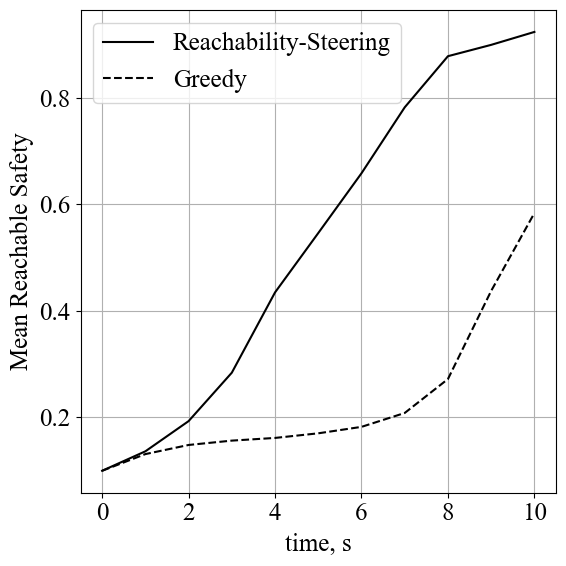

In [76]:
# font size
fontsize = 18
plt.figure(figsize=(6, 6))
plt.plot(np.arange(11), hda_rs.mean_safety_list, 'k-', label='Reachability-Steering')
plt.plot(np.arange(11), hda_greedy.mean_safety_list, 'k--', label='Greedy')
plt.xlabel('time, s', fontsize=fontsize)
plt.ylabel('Mean Reachable Safety', fontsize=fontsize)
plt.legend(fontsize=fontsize)
plt.tick_params(labelsize=fontsize)
# tight layout
plt.tight_layout()
# grid
plt.grid(True)
# save
plt.savefig('../saved/fig/mean_reachable_safety.pdf')